In [ ]:
import numpy as np
import math as math
import numpy.linalg as LA
import cv2
from google.colab.patches import cv2_imshow

# Funckija koja racuna teziste skupa tacaka u 2D
def izracunaj_teziste(tacke):
  n = len(tacke)
  C_x = 0
  C_y = 0

  for tacka in tacke:
    C_x += tacka[0]
    C_y += tacka[1]

  return (C_x/n, C_y/n)

def izracunaj_prosek_rastojanja(tacke):
  rastojanje = 0
  n = len(tacke)
  for tacka in tacke:
    rastojanje += math.sqrt(tacka[0]**2 + tacka[1]**2)

  return rastojanje/n    
'''
 Funckija koja vrsi normalizaciju tako sto prvo svaku tacku u skupu translira za vektor CO
 gde je C teziste skupa tacaka, a O koordinatni pocetak. Zatim se vrsi skaliranje kooridnata
 tako da prosecno rastojanje skupa tacaka do koordinatnog pocetka bude sqrt(2). Ovako dobijen
 skup tacaka se naziva normalizovan.
'''
def normalizuj(tacke):

  (C_x, C_y) = izracunaj_teziste(tacke)

  nova_lista = []
  for tacka in tacke:
    x = tacka[0] - C_x
    y = tacka[1] - C_y
    nova_lista.append([x, y])

  lam = izracunaj_prosek_rastojanja(nova_lista)
  tacke = []

  for tacka in nova_lista:
    x = (tacka[0]/lam)*math.sqrt(2)
    y = (tacka[1]/lam)*math.sqrt(2)
    tacke.append([x, y])

  matrica_translacije = np.array([[1, 0, -C_x], [0, 1, -C_y], [0, 0, 1]])
  matrica_homotetije = np.array([[math.sqrt(2)/lam, 0, 0], [0, math.sqrt(2)/lam, 0], [0, 0, 1]])
  matrica_transformacije = matrica_homotetije @ matrica_translacije

  return tacke, matrica_transformacije

tacke = [[1, 1], [5, 2], [6, 4], [-1, 7]]
tacke, matrica = normalizuj(tacke)
print(tacke)
print(matrica)


[[-0.698445552349397, -0.9977793604991386], [0.8980014244492246, -0.5986676162994831], [1.2971131686488802, 0.19955587209982772], [-1.4966690407487078, 1.396891104698794]]
[[ 0.39911174  0.         -1.0975573 ]
 [ 0.          0.39911174 -1.3968911 ]
 [ 0.          0.          1.        ]]


In [ ]:
def prebaci_u_projektivne(tacke):
  lista = []
  for tacka in tacke:
    x = tacka[0]
    y = tacka[1]
    lista.append([x, y, 1])
  return lista

def prebaci_u_afine(tacke):
  lista = []
  for tacka in tacke:
    x = tacka[0]/tacka[2]
    y = tacka[1]/tacka[2]
    lista.append([x, y])
  return lista

# Funkcija koja formira matricu cije su kolone redom vektori A, B i C

def formiraj_matricu(A, B, C):
  array = np.array([A, B, C]).T
  return array

def izvuci_kolone(matrica):
  prva_kolona = []
  for i in range(3):
    prva_kolona.append(matrica[i][0])
  druga_kolona = []
  for i in range(3):
    druga_kolona.append(matrica[i][1])
  treca_kolona = []
  for i in range(3):
    treca_kolona.append(matrica[i][2])

  return prva_kolona, druga_kolona, treca_kolona

'''
  Ova funkcija predstavlja implementaciju naivnog algoritma za odredjivanje 
  matrice projektivnog preslikavanja za otklanjanje projektivne distorzije.
'''

def naivni(originali, slike):
  if (len(originali) != 4 or len(slike) != 4 or len(originali) != len(slike)):
    print("Funckija prima tacno 4 tacke!")
    return None

  originali = prebaci_u_projektivne(originali)
  slike = prebaci_u_projektivne(slike)
  
  A1, B1, C1, D1 = originali[0], originali[1], originali[2], originali[3]
  A2, B2, C2, D2 = slike[0], slike[1], slike[2], slike[3]
  D1 = np.array([D1]).T
  D2 = np.array([D2]).T

  matrica_1 = formiraj_matricu(A1, B1, C1)
  matrica_2 = formiraj_matricu(A2, B2, C2)
  
  # Potrbno je pronaci alfa, beta i gama iz izraza
  # D1 = alfa*A1 + beta*B1 + gama*C1
  # Slicno vazi i za kolone matrice matrica_2
  
  X = np.linalg.inv(matrica_1).dot(D1)
  Y = np.linalg.inv(matrica_2).dot(D2)

  prva_kolona, druga_kolona, treca_kolona = izvuci_kolone(matrica_1)
  P1 = formiraj_matricu(X[0]*prva_kolona, X[1]*druga_kolona, X[2]*treca_kolona)

  prva_kolona, druga_kolona, treca_kolona = izvuci_kolone(matrica_2)
  P2 = formiraj_matricu(Y[0]*prva_kolona, Y[1]*druga_kolona, Y[2]*treca_kolona)

  P = np.matmul(P2, LA.inv(P1))
  return P

print(naivni([[1, 1], [5, 2], [6, 4], [-1, 7]], [[0, 0], [10, 0], [10, 5], [0, 5]]))

[[ 0.44871795  0.14957265 -0.5982906 ]
 [-0.19230769  0.76923077 -0.57692308]
 [-0.07277526  0.07378079  0.41075918]]


In [ ]:
'''
  Ova funkcija predstavlja implementaciju DLT algoritma za odredjivanje matrice
  projektivnog preslikavanja radi otklanjanja projektivne distorzije
'''

def DLT(originali, slike):
  if(len(originali) < 4 or len(slike) < 4 or len(originali) != len(slike)):
    print("Losi argumenti funkcije!")
    return None

  n = len(originali)

  originali = prebaci_u_projektivne(originali)
  slike = prebaci_u_projektivne(slike)

  matrica = np.array([]).reshape(0, 9)

  for i in range(0, n):
    tacka1 = originali[i]
    tacka2 = slike[i]

    pomocna = np.array([[0, 0, 0, -tacka2[2]*tacka1[0], -tacka2[2]*tacka1[1], -tacka2[2]*tacka1[2], tacka2[1]*tacka1[0], tacka2[1]*tacka1[1], tacka2[1]*tacka1[2]], 
                              [tacka2[2]*tacka1[0], tacka2[2]*tacka1[1], tacka2[2]*tacka1[2], 0, 0, 0, -tacka2[0]*tacka1[0], -tacka2[0]*tacka1[1], -tacka2[0]*tacka1[2]]])

    matrica = np.concatenate((matrica, pomocna), axis=0)

  _, _, v = np.linalg.svd(matrica, full_matrices=True)

  v = v[-1]
  return np.array([[v[0], v[1], v[2]], [v[3], v[4], v[5]], [v[6], v[7], v[8]]])

print("Matrica transformacije dobijena naivnim algoritmom:")
print(naivni([[1, 1], [5, 2], [6, 4], [-1, 7]], [[0, 0], [10, 0], [10, 5], [0, 5]]))
print('-------------------------------------------------------------')
print("Matrica transformacije dobijena DLT algoritmom:")
print(DLT([[1, 1], [5, 2], [6, 4], [-1, 7]], [[0, 0], [10, 0], [10, 5], [0, 5]]))


Matrica transformacije dobijena naivnim algoritmom:
[[ 0.44871795  0.14957265 -0.5982906 ]
 [-0.19230769  0.76923077 -0.57692308]
 [-0.07277526  0.07378079  0.41075918]]
-------------------------------------------------------------
Matrica transformacije dobijena DLT algoritmom:
[[ 0.3418787   0.11395957 -0.45583826]
 [-0.14651944  0.58607777 -0.43955833]
 [-0.05544755  0.05621367  0.31295787]]


In [ ]:
'''
  Ova funkcija predstavlja implementaciju unapredjenog DLT algoritma za odredjivanje 
  matrice projektivnog preslikavanja radi otklanjanja projektivne distorzije
'''

def DLT_unapredjeni(originali, slike):
  originali, matrica1 = normalizuj(originali)
  slike, matrica2 = normalizuj(slike)

  matrica = DLT(originali, slike)

  return np.linalg.inv(matrica2) @ matrica @ matrica1

print(DLT_unapredjeni([[1, 1], [5, 2], [6, 4], [-1, 7]], [[0, 0], [10, 0], [10, 5], [0, 5]]))
print()
print(DLT_unapredjeni([[3, 2], [4, -2], [6, -3], [9, 4]], [[5, -2], [15, 8], [10, 13], [0, 3]]))

[[ 0.49851447  0.16617149 -0.66468596]
 [-0.21364906  0.85459623 -0.64094717]
 [-0.08085151  0.08196863  0.45634321]]

[[-0.27858161 -0.30790599  3.7388585 ]
 [ 0.85683047 -0.44656842 -2.59227523]
 [ 0.08196863  0.08085151  0.04985145]]


In [ ]:
'''
  U ovom delu koda uporedicemo rad DLT i unapredjenog DLT algoritma i pokazati
  da je unapredjeni DLT algoritam otporan na promenu koordinata
'''

originali = np.array([[-5,0,1], [-6,0.5,1], [-5,3,1], [-4,2,1], [-2,1.5,1], [-4,0,1]])
slike = np.array([[3,0,1], [1,1.5,1], [2.7,2.5,1], [6,2,1], [6.5,0.5,1], [4,0,1]])

#originali = np.array([[1, 1], [5, 2], [6, 4], [-1, 7]])
#slike = np.array([[0, 0], [10, 0], [10, 5], [0, 5]])

originali_proj = np.array(prebaci_u_projektivne(originali))
slike_proj = np.array(prebaci_u_projektivne(slike))

matricaDLT = DLT(originali, slike)
matricaDLTUn = DLT_unapredjeni(originali, slike)

# Skaliranje matrica radi uporedjivanja
matricaDLT = matricaDLT / (matricaDLTUn[0][0] / matricaDLT[0][0])
matricaDLTUn = matricaDLTUn / (matricaDLTUn[0][0] / matricaDLT[0][0])

print("Matrica transformacije dobijena DLT algoritmom:")
print(matricaDLT)
print()
print("Matrica transformacije dobijena unapredjenim DLT algoritmom:")
print(matricaDLTUn)
print()

# Martrice transformacije radi menjanja koordinata
transf_orig = np.array([[0, 1, 2], [-1, 0, 3], [0, 0, 1]])
transf_slik = np.array([[1, -1, 5], [1, 1, -2], [0, 0, 1]])

# Mapiranje tacaka u novi koordinatni sistem
originali = np.array([*map(lambda x: transf_orig @ x.T, originali_proj)])
slike = np.array([*map(lambda x: transf_slik @ x.T, slike_proj)])

originali = prebaci_u_afine(originali)
slike = prebaci_u_afine(slike)

matrica_ = np.array(DLT_unapredjeni(originali, slike))
print("Matrica dobijenja unapredjenim DLT algoritmom sa izmenjenim koordinatama:")
print(matrica_)
print()
print("Matrica dobijena kada se vratimo u stare koordinate:")
print(LA.inv(transf_slik)@matrica_ @ transf_orig)


Matrica transformacije dobijena DLT algoritmom:
[[-0.01669762  0.0063853  -0.10466085]
 [-0.00035207 -0.00079422 -0.00390918]
 [-0.00198311  0.00219739 -0.01675162]]

Matrica transformacije dobijena unapredjenim DLT algoritmom:
[[-0.01669762  0.0055689  -0.10613521]
 [ 0.00030767 -0.00187771 -0.00064518]
 [-0.0017455   0.00207207 -0.01631189]]

Matrica dobijenja unapredjenim DLT algoritmom sa izmenjenim koordinatama:
[[-1.53788019 -2.22238885 25.89727977]
 [ 0.03911862 -1.11400472  9.66824144]
 [-0.17895211 -0.15074866  2.21891157]]

Matrica dobijena kada se vratimo u stare koordinate:
[[ 1.44207379 -0.48095261  9.16626664]
 [-0.02657175  0.16216701  0.05572057]
 [ 0.15074866 -0.17895211  1.40876135]]


In [ ]:
def test():
  # Slucaj sa cetiri tacke
  orig = np.array([[-5,0,1], [-6,0.5,1], [-5,3,1], [-4,2,1]])
  nove = np.array([[3,0,1], [1,1.5,1], [2.7,2.5,1], [6,2,1]])

  print('Originalne tačke:')
  print(orig)
  print()

  print('Njihove slike:')
  print(nove)
  print()

  print('Matrica koju nam daje naivni algoritam:')
  naiv = naivni(nove, orig)
  print(naiv)
  print()

  print('Matrica koju nam daje DLT algoritam:')
  dlt = DLT(nove, orig)
  print(dlt)
  print()

  print('Skalirana DLT matrica:')
  print(naiv[0][0]/dlt[0][0] * dlt)
  print()

  print('Zaključak: u pitanju je ista transformacija.')
  print()

  print('Matrica koju nam daje unapredjeni DLT algoritam:')
  mdlt = DLT_unapredjeni(nove, orig)
  print(mdlt)
  print()

  print('Skalirana matrica unapredjenog DLT algoritma:')
  print(dlt[0][0]/mdlt[0][0] * mdlt)
  print()

  print('Zaključak: u pitanju je ista transformacija.')
  print()

  # Slucaj sa vise tacaka
  orig = np.array([[-5,0,1], [-6,0.5,1], [-5,3,1],
                   [-4,2,1], [-2,1.5,1], [-4,0,1]])
  nove = np.array([[3,0,1], [1,1.5,1], [2.7,2.5,1],
                   [6,2,1], [6.5,0.5,1], [4,0,1]])

  print('Originalne tačke:')
  print(orig)
  print()

  print('Njihove slike:')
  print(nove)
  print()

  print('Matrica koju nam vraca DLT algoritam bez šuma:')
  dlt0 = DLT(nove, orig)
  print(dlt0)
  print()

  print('Matrica koju nam vraca unapredjeni DLT algoritam bez šuma:')
  mdlt0 = DLT_unapredjeni(nove, orig)
  print(mdlt0)
  print()

  print('Skalirana matrica unapredjenog DLT algoritma:')
  print(dlt0[0][0]/mdlt0[0][0] * mdlt0)
  print()

  print('Zaključak: više tačaka unosi višeznačnost.')
  print('Sada se skaliranjem matirca unapredjenoh DLT algorima ne dobija ista matrica kao za DLT.')
  print()

  # Slucaj sa sumom
  orig[2], nove[0] = [-5.1,3,1], [3.1,0,1]

  print('Originali sa šumom:')
  print(orig)
  print()

  print('Slike sa šumom:')
  print(nove)
  print()

  print('DLT sa šumom:')
  dlt1 = DLT(nove, orig)
  print(dlt1)
  print()

  print('Skalirana matrica DLT algoritma:')
  print(dlt0[0][0]/dlt1[0][0] * dlt1)
  print()

  print('Matrica unapredjenog DLT algoritma sa šumom:')
  mdlt1 = DLT_unapredjeni(nove, orig)
  print(mdlt1)
  print()

  print('Skalirana matrica unapredjenog DLT algoritma:')
  print(mdlt0[0][0]/mdlt1[0][0] * mdlt1)
  print()

  print('Zaključak: šum donekle utiče na transformaciju.')

test()

Originalne tačke:
[[-5.   0.   1. ]
 [-6.   0.5  1. ]
 [-5.   3.   1. ]
 [-4.   2.   1. ]]

Njihove slike:
[[3.  0.  1. ]
 [1.  1.5 1. ]
 [2.7 2.5 1. ]
 [6.  2.  1. ]]

Matrica koju nam daje naivni algoritam:
[[-0.28906476  1.6313883  -5.52838806]
 [ 0.28685548  0.56971678 -0.86056645]
 [ 0.11954135 -0.31887025  0.92049243]]

Matrica koju nam daje DLT algoritam:
[[ 0.04857115 -0.27411991  0.92892738]
 [-0.04819993 -0.09572872  0.14459979]
 [-0.02008637  0.05357933 -0.15466907]]

Skalirana DLT matrica:
[[-0.28906476  1.6313883  -5.52838806]
 [ 0.28685548  0.56971678 -0.86056645]
 [ 0.11954135 -0.31887025  0.92049243]]

Zaključak: u pitanju je ista transformacija.

Matrica koju nam daje unapredjeni DLT algoritam:
[[-0.16322285  0.92117714 -3.12165086]
 [ 0.16197536  0.32169537 -0.48592609]
 [ 0.06750003 -0.18005277  0.5197638 ]]

Skalirana matrica unapredjenog DLT algoritma:
[[ 0.04857115 -0.27411991  0.92892738]
 [-0.04819993 -0.09572872  0.14459979]
 [-0.02008637  0.05357933 -0.1546690

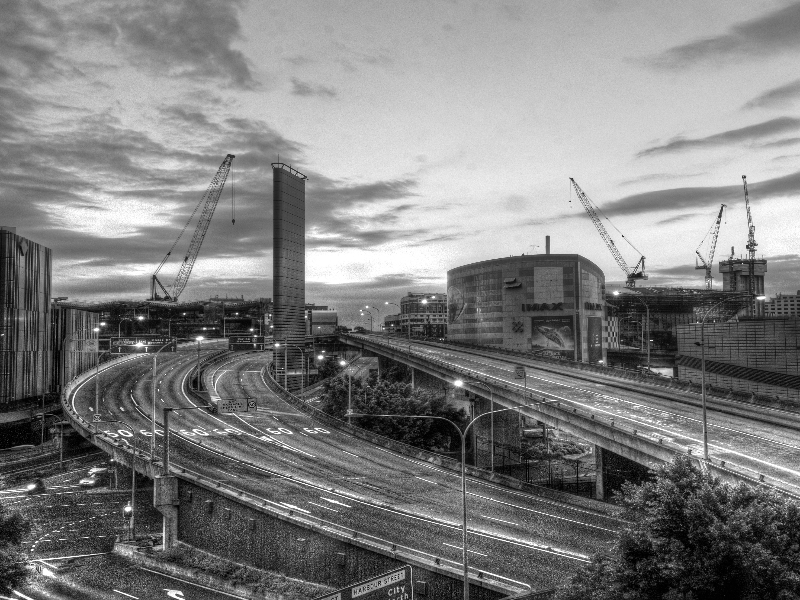

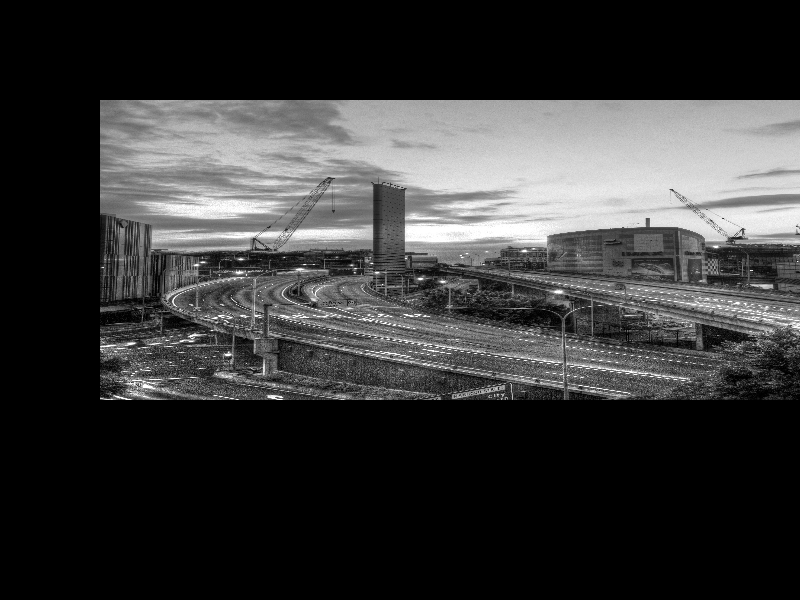

In [25]:
def otklanjanje_projektivne_distorzije():
  img = cv2.imread('1.jpg')
  img = cv2.resize(img, (800, 600))

  src_pts = [[0, 0], [0, 20], [100, 0], [100, 20]]
  dst_pts = [[100, 100], [100, 110], [200, 100], [200, 110]]

  matrix = DLT(src_pts, dst_pts)

  dst = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))

  #dst = cv2.resize(dst, (800, 600))
  cv2_imshow(dst)

otklanjanje_projektivne_distorzije()

In [ ]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

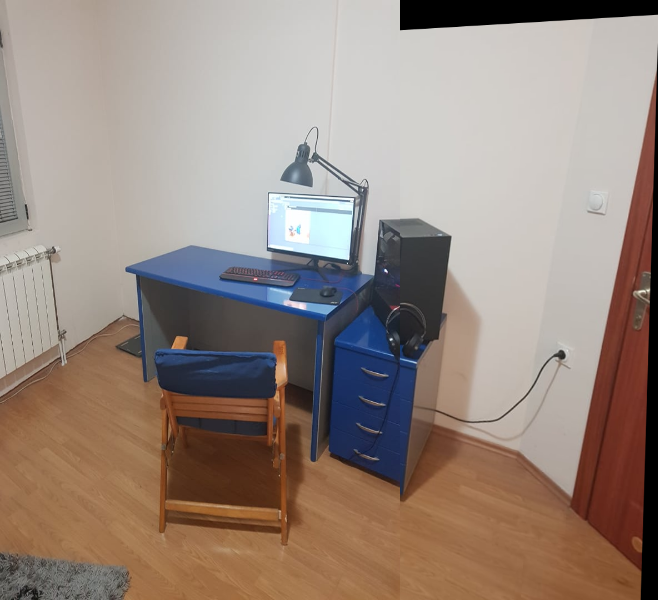

In [30]:
def panorama():

    img_right = cv2.imread('desna.jpg')
    img_left = cv2.imread('leva.jpg')

    img1 = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create()

    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()

    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 1*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10

    if(len(good) > MIN_MATCH_COUNT):
        src_points = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_points = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

        h, w = img1.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
        #cv2.imshow("Overlap", img2)
        cv2.waitKey(10000)
    else:
        print("Not enough matches are found!")
        exit(1)

    dst = cv2.warpPerspective(img_right, M, (img_left.shape[1] + img_right.shape[1], img_left.shape[0]))
    dst[0:img_left.shape[0], 0:img_left.shape[1]] = img_left
    dst = cv2.resize(dst, (800, 600))
    cv2_imshow(trim(dst))

panorama()